# Review sentiment classification using pre-trained language models

The goal of this project is to classify the sentiment of hotel reviews from booking.com using pre-trained language models. Specifically, we aim to fine-tune popular pre-trained language models and compare their performance. This notebook builds on the previous work done on the same dataset, where classification and deep learning models were employed to perform the same task. Through this project, we hope to determine which pre-trained language model is the most accurate for this task.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BartTokenizer, BartForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# import the data
reviews_data = pd.read_csv('C:/Hotel_Reviews_Booking.csv')
reviews_data = reviews_data[:1500]

### Prepare the reveiws dataset
pos_df = reviews_data[['Positive_Review']].copy()
pos_df.columns = ['Review']
pos_df.loc[:, 'Sentiment'] = 1 #positive

neg_df = reviews_data[['Negative_Review']].copy()
neg_df.columns = ['Review']
neg_df.loc[:, 'Sentiment'] = 0 #negative

clf_df = pd.concat([pos_df,neg_df])
clf_df = clf_df.drop_duplicates().reset_index(drop=True)
clf_df = clf_df.sample(frac=1).reset_index(drop=True)
clf_df

,Review,Sentiment
0,The room was tiny and for that reason we woul...,0
1,There were renovations going on that made it ...,0
2,The bathroom door was hanging off the light f...,0
3,The location was perfect close to the Undergr...,1
4,Never change the used cups,0
...,...,...
2472,Customer service and cleanliness of rooms,0
2473,Excellent location when arriving in car,1
2474,Location is good about 8 mins walk to the tub...,1
2475,very confy bed Great bar with lovely staff,1


1    1412
0    1065
Name: Sentiment, dtype: int64


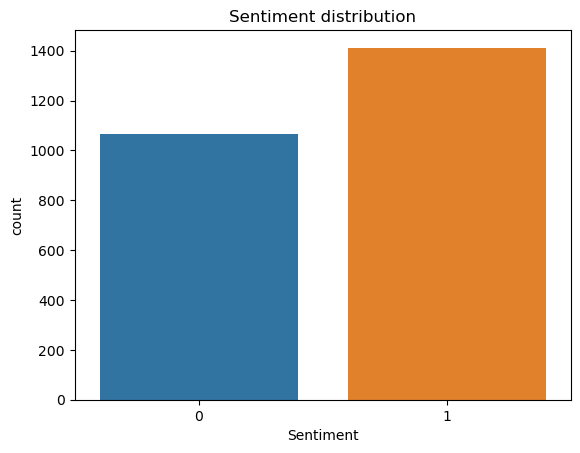

In [3]:
# Check the imbalance in the data
print(clf_df['Sentiment'].value_counts())
sns.countplot(x='Sentiment', data=clf_df)
plt.title('Sentiment distribution')
plt.show()

In [4]:
# set parameters
epochs = 4
batch_size = 16

In [5]:
# track models performance
log_models = pd.DataFrame(columns=["Model","Accuracy","Precision","Recall","F1-score"])

## Pre-trained language models

In [5]:
def data_preparation(clf_df, tokenizer):
    reviews = clf_df['Review'].values
    labels = clf_df['Sentiment'].values

    # Preprocess data
    input_ids = []
    attention_masks = []

    for review in reviews:
        encoded_dict = tokenizer.encode_plus(
                            review,                      # Review to encode
                            add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
                            max_length = 256,            # Pad & truncate all sentences
                            truncation=True,
                            pad_to_max_length = True,
                            return_attention_mask = True, # Construct attn. masks
                            return_tensors = 'pt',       # Return pytorch tensors
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Split data into train and validation sets
    train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
    train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)
    
    return train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks

def training(model, train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks):
    
    # Train the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i in range(0, train_inputs.size(0), batch_size):
            inputs = train_inputs[i:i+batch_size].to(device)
            masks = train_masks[i:i+batch_size].to(device)
            labels = train_labels[i:i+batch_size].to(device)

            model.zero_grad()        
            #outputs = model(inputs, token_type_ids=None, attention_mask=masks, labels=labels)
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        avg_train_loss = total_loss / len(train_inputs)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}')

        # Evaluate on validation set
        model.eval()
        val_preds = []
        with torch.no_grad():
            for i in range(0, val_inputs.size(0), batch_size):
                inputs = val_inputs[i:i+batch_size].to(device)
                masks = val_masks[i:i+batch_size].to(device)
                labels = val_labels[i:i+batch_size].to(device)

                #outputs = model(inputs, token_type_ids=None, attention_mask=masks)
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1).flatten()
                val_preds.extend(preds.cpu().detach().numpy())
    
    return val_labels, val_preds

def evaluate(labels, predicted):
    accuracy = accuracy_score(labels, predicted)
    precision = skmetrics.precision_score(labels, predicted, average='weighted')
    recall = skmetrics.recall_score(labels, predicted, average='weighted')
    f1 = skmetrics.f1_score(labels, predicted, average='weighted')
    print('\nAccuracy of the model on the test data: {:.2f}%'.format(accuracy * 100))
    print('Precision of the model: {:.2f}%'.format(precision * 100))
    print('Recall of the model: {:.2f}%'.format(recall * 100))
    print('F1-score of the model: {:.2f}%'.format(f1 * 100))

    return accuracy, precision, recall, f1

### BERT

BERT is a pre-trained language model that can understand the context of words in a sentence. This ability helps it to accurately understand the meaning of the text, which is especially important for sentiment analysis since the sentiment of a sentence can depend on its context. Another advantage of BERT is that it can be fine-tuned on small datasets to achieve high accuracy, which makes it a suitable choice for this task.

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = data_preparation(clf_df, tokenizer)

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 2, 
    output_attentions = False,output_hidden_states = False,)

val_labels, val_preds = training(model, train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks)

accuracy, precision, recall, f1 = evaluate(val_labels.cpu().numpy(), val_preds)
log_models.loc[len(log_models)] = ['BERT',accuracy, precision, recall, f1]

C:\Users\israe\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenc

Epoch 1/4, Training Loss: 0.016094336311574056
Epoch 2/4, Training Loss: 0.005760120520587298
Epoch 3/4, Training Loss: 0.0036163037854511477
Epoch 4/4, Training Loss: 0.0014539221478560313

Accuracy of the model on the test data: 96.37%
Precision of the model: 96.39%
Recall of the model: 96.37%
F1-score of the model: 96.38%


### BART

BART is a pre-trained language model that offers some advantages over BERT for text classification tasks. One of the main advantages is its ability to handle variable-length input sequences. Furthermore, BART is trained on a denoising auto-encoder objective, which requires the model to reconstruct a corrupted version of the input sequence. This training process helps BART to learn to compress and summarize text effectively, which can be useful for tasks like sentiment analysis where the relevant information may be spread across the text.

In [13]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = data_preparation(clf_df, tokenizer)

# Initialize the BART model
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=2)

val_labels, val_preds = training(model, train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks)

accuracy, precision, recall, f1 = evaluate(val_labels.cpu().numpy(), val_preds)
log_models.loc[len(log_models)] = ['BART',accuracy, precision, recall, f1]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.out_proj.bias', 'classification_head.dense.bias', 'classification_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Training Loss: 0.01697491858683899
Epoch 2/4, Training Loss: 0.00906898228088201
Epoch 3/4, Training Loss: 0.0073792044525429635
Epoch 4/4, Training Loss: 0.004995327849485966

Accuracy of the model on the test data: 96.37%
Precision of the model: 96.37%
Recall of the model: 96.37%
F1-score of the model: 96.37%


### RoBERTa

RoBERTa is a modification of the BERT architecture, which has been trained on a larger dataset. This means that RoBERTa has seen a greater variety of language and can potentially capture more subtle nuances in sentiment. Additionally, RoBERTa's dynamic masking approach improves the model's ability to capture context dependencies and long-term dependencies in the input sequence.

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = data_preparation(clf_df, tokenizer)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

val_labels, val_preds = training(model, train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks)

accuracy, precision, recall, f1 = evaluate(val_labels.cpu().numpy(), val_preds)
log_models.loc[len(log_models)] = ['RoBERTa',accuracy, precision, recall, f1]

C:\Users\israe\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with anothe

Epoch 1/4, Training Loss: 0.02041898718445079
Epoch 2/4, Training Loss: 0.00881889602610139
Epoch 3/4, Training Loss: 0.0050167632999711005
Epoch 4/4, Training Loss: 0.004399278058714183

Accuracy of the model on the test data: 97.58%
Precision of the model: 97.59%
Recall of the model: 97.58%
F1-score of the model: 97.58%


### ELECTRA

ELECTRA is another pre-trained language model that differs from BERT and RoBERTa. While BERT and RoBERTa are pre-trained using masked language modeling, ELECTRA is pre-trained using a different approach called replaced token detection. Additionally, ELECTRA has been shown to have faster training times and requires less memory than BERT and RoBERTa. This is because instead of masking tokens in the input, ELECTRA trains the model to predict whether tokens have been replaced with plausible substitutes. This approach has been shown to be more effective in certain tasks, including sentiment analysis.

In [7]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = data_preparation(clf_df, tokenizer)

# Initialize the ELECTRA model
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2)

val_labels, val_preds = training(model, train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks)

accuracy, precision, recall, f1 = evaluate(val_labels.cpu().numpy(), val_preds)
log_models.loc[len(log_models)] = ['ELECTRA',accuracy, precision, recall, f1]

C:\Users\israe\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with ano

Epoch 1/4, Training Loss: 0.018638559248992315
Epoch 2/4, Training Loss: 0.007035974591334831
Epoch 3/4, Training Loss: 0.005350091090427729
Epoch 4/4, Training Loss: 0.0035202814908279786

Accuracy of the model on the test data: 97.38%
Precision of the model: 97.38%
Recall of the model: 97.38%
F1-score of the model: 97.38%


### Model comparison

In [8]:
log_models = log_models.set_index('Model')
log_models = log_models.sort_values(by="F1-score",ascending=False)
log_models

,Accuracy,Precision,Recall,F1-score
Model,,,,
RoBERTa,0.975806,0.975865,0.975806,0.975820
ELECTRA,0.973790,0.973803,0.973790,0.973760
BERT,0.963710,0.963927,0.963710,0.963754
BART,0.963710,0.963710,0.963710,0.963710


##### Metrics scores

<Figure size 700x600 with 0 Axes>

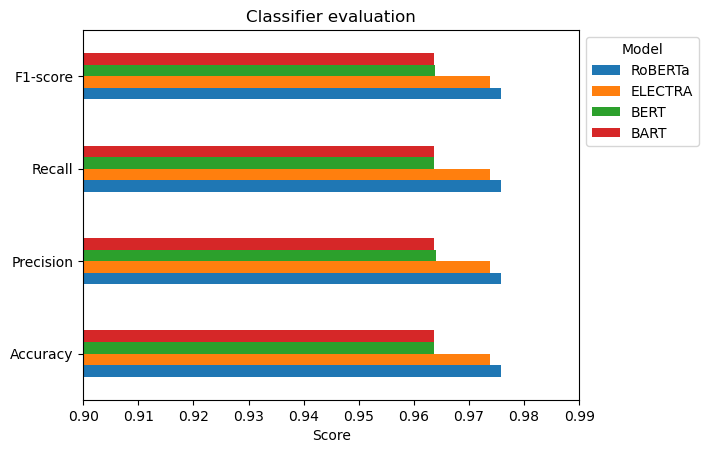

In [9]:
plt.figure(figsize=(7, 6))
log_models[['Accuracy','Precision','Recall','F1-score']].T.plot.barh()
plt.title('Classifier evaluation')
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.xlabel('Score')
plt.xlim((0.90,0.99))
plt.show()

Based on the performance metrics shown, the RoBERTa and ELECTRA models performed the best, followed by BERT with a slightly lower score, and BART with the lowest score. However, there is no significant difference between the models.

Compared to our previous project where we explored deep learning models, the pre-trained language models examined in this project have shown to outperform the models we used previously. However, it should be noted that the performance can vary depending on the characteristics of the dataset, and further testing may be required to evaluate the performance of the models on different datasets.